# Minería de Datos - Otoño 2018

## Primer Parcial (para llevar)

### Instrucciones de entrega 

Si elegiste esta versión del examen, se debe enviar un correo a `isimoninw@gmail.com` con este notebook a más tardar a las 11:59 pm del domingo 14 de octubre. Si se recibe el correo después de esta hora no se contará, así que es mejor enviar lo que se tenga antes de esta hora a intentar terminar.

El asunto del correo debe ser:
"Examen - Clave Única - Nombre completo"

> Ejemplo:

> Asunto: Examen - 100020 - Fulanito de Tal

El **nombre** del archivo contenido en el correo debe tener el formato `claveunica_nombre_apellidos.ipynb`

Cualquier desviación de estas indicaciones será motivo de disminución de puntaje.

### ¿Cómo contestar?

Siéntete libre de hacer más celdas cuando sean necesarias, pero intenta hacer el código/texto lo más legible posible.

El resultado final de este notebook debe ser un reporte autocontenido y comprensible. Sé lo más claro posible en tus explicaciones y justificaciones.

### Los Datos

Los datos usados durante este examen consisten en una colección de mensajes de texto (SMS) etiquetados como spam o no spam (ham).

La diferencia entre la versión en clase y esta versión del examen es que se extraerán distintas variables del texto antes de contestar las preguntas.

Por esto, en la carpeta datos/ encontrarás el archivo `spam.csv` con los datos crudos.

## Parte 1: Preprocesamiento

Para esta parte, puedes usar como guía la documentación de sklearn para [trabajar con texto](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

### 1.1 Separar en entrenamiento y prueba
### 1.2 Crear un codificador de texto a matriz usando [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) con los datos de entrenamiento
### 1.3 Crear un codificador de texto a matriz usando [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) con los datos de entrenamiento
### 1.4 Transformar los datos usando los codificadores, creando 4 matrices de variables: X_bow_train, X_bow_test, X_tfidf_train, X_tfidf_test
### 1.5 ¿Por qué es importante crear los codificadores usando solo el conjunto de entrenamiento?
### 1.6 ¿Las clases están balanceadas? ¿Cuál es la proporción de spam que hay en los datos?

In [1]:
# Cargar librerias
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

Cambié el archivo de datos por un txt guardado con encoding UTF-8 porque no leía el .csv por errores de encoding, vamos a cargar los datos en un DataFrame **spam**

In [2]:
spam = pd.read_csv('spam_utf8.txt', encoding='utf-8')
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Observamos que hay 3 variables sin nombre que se deben a emails que ocupan más de una celda, vamos a concatenar todas las variables en una sola y por mera comodidad se codificará la variable respuesta, **v1**, como 0:= ham, 1:= spam

In [3]:
spam.fillna(value='', axis=1, inplace=True)
spam['v3'] = spam.v2 + spam['Unnamed: 2'] + spam['Unnamed: 3'] + spam['Unnamed: 4']
spam['target'] = spam.v1.map(lambda x: 1 if x == 'spam' else 0)
spam = spam.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'v2', 'v1'], axis = 1)
spam.head()

,v3,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Como se nos pide, vamos a separar los datos en entrenamiento y prueba

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    spam.v3, # X
    spam.target,  # y
    test_size=0.4, # porcentaje que será prueba
    random_state=42) # para fijar el aleatorio (reproducibilidad)

Codificaremos los datos de entrenamiento usando el modelo *bag of words*:

In [5]:
Vectorizer = CountVectorizer()
Vectorizer.fit(X_train)
X_bow_train = pd.DataFrame(Vectorizer.transform(X_train).toarray(), 
                         columns=Vectorizer.get_feature_names())
X_bow_test = pd.DataFrame(Vectorizer.transform(X_test).toarray(), 
                         columns=Vectorizer.get_feature_names())

Sigamos con codificar con el método *TF-IDF*:

In [6]:
tf_transformer = TfidfVectorizer()
tf_transformer.fit(X_train)

X_tfidf_train = tf_transformer.transform(X_train)
X_tfidf_train = pd.DataFrame(X_tfidf_train.toarray(), 
                             columns=tf_transformer.get_feature_names())

X_tfidf_test = tf_transformer.transform(X_test)
X_tfidf_test = pd.DataFrame(X_tfidf_test.toarray(), 
                            columns=tf_transformer.get_feature_names())

Aprovechemos este punto para observar que ambos métodos **fit()** reciben como parámetro los datos separados para entrenamiento, pues lo que haremos es contar repeticiones de cada palabra por cada renglón y no debemos usar los de prueba, pues sería como hacer trampa, estaríamos calificando palabras que no conocemos aún.

Veamos si las clases están balanceadas:

In [7]:
spam.target.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: target, dtype: float64

Tenemos sólo el 13% de éxitos, mensaje spam, por tanto no está balanceado el problema

## Parte 2: Bag of Words

### 2.1 Scikit-learn tiene los clasificadores Naive Bayes: MultinomialNB, BernoulliNB, and GaussianNB. ¿Cuál(es) podrían modelar estos datos y por qué?

### 2.2 Entrena un modelo Naive Bayes (usando la versión de NB que te parezca adecuada) para clasificar si es o no spam un mensaje.

### 2.3 Entrena un Random Forest para clasificar si es o no spam un mensaje. Usa Cross Validation para optimizar al menos un hiperparámetro y muestra cuál es el mejor valor para ese parámetro.

Podemos usar el modelo Naive Bayes Multinomial porque estamos considerando conteos para cada palabra, por tanto vamos a entrenar los modelos:

In [8]:
nb = MultinomialNB(fit_prior=False).fit(X_bow_train, y_train)
grid_parametros = {'n_estimators': [50, 75, 100, 125, 150]}

rf_cv = GridSearchCV(RandomForestClassifier(), grid_parametros,
                    verbose=10, n_jobs=-1, scoring='f1_micro')

rf_cv.fit(X_bow_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   25.2s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   32.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   39.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 75, 100, 125, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=10)

Lo cual nos otorga las siguientes métricas:

In [9]:
y_test = pd.DataFrame(list(y_test), columns=['target'])
y_test['pred_bow_rf'] = rf_cv.predict(X_bow_test)
y_test['pred_bow_nb'] = nb.predict(X_bow_test)
predicted_proba = {}
predicted_proba['bow_nb'] = nb.predict_proba(X_bow_test)
predicted_proba['bow_rf'] = rf_cv.predict_proba(X_bow_test)
rf_cm = confusion_matrix(y_test.target, y_test.pred_bow_rf)
nb_cm = confusion_matrix(y_test.target,  y_test.pred_bow_nb)

TP = rf_cm[1][1]
TN = rf_cm[0][0]
FP = rf_cm[0][1]
FN = rf_cm[1][0]

precision_rf = TP / (TP + FP)
recall_rf = TP / (TP + FN)
f1_score_rf = 2 * precision_rf * recall_rf / (precision_rf + recall_rf)


TP = nb_cm[1][1]
TN = nb_cm[0][0]
FP = nb_cm[0][1]
FN = nb_cm[1][0]

precision_nb = TP / (TP + FP)
recall_nb = TP / (TP + FN)
f1_score_nb = 2 * precision_nb * recall_nb / (precision_nb + recall_nb)

df_final = pd.DataFrame({'Codificador' : ['Bag of words', 'Bag of words'],
                         'Modelo': ['Random Forest', 'Naive Bayes'],
                         'Precision': [precision_rf, precision_nb],
                         'Recall': [recall_rf, recall_nb],
                         'F1_score': [f1_score_rf, f1_score_nb]})
df_final

,Codificador,Modelo,Precision,Recall,F1_score
0,Bag of words,Random Forest,1.000000,0.826087,0.904762
1,Bag of words,Naive Bayes,0.896104,0.923077,0.909390


## Parte 3: TF-IDF

### 3.1 Intenta superar la predicción de Bag of Words usando los datos transformados a través de TF-IDF

Vamos a entrenar los modelos Random Forest y Naive Bayes con los datos codificados por *TF-IDF*

In [10]:
nb = MultinomialNB(fit_prior=False).fit(X_tfidf_train, y_train)
grid_parametros = {'n_estimators': [50, 75, 100, 125, 150]}

rf_cv = GridSearchCV(RandomForestClassifier(), grid_parametros,
                    verbose=10, n_jobs=-1, scoring='f1_micro')

rf_cv.fit(X_tfidf_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   25.9s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   32.6s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   38.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 75, 100, 125, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=10)

Análogamente, obtenemos las siguientes métricas:

In [11]:
y_test['pred_tf_rf'] = rf_cv.predict(X_tfidf_test)
y_test['pred_tf_nb'] = nb.predict(X_tfidf_test)
predicted_proba['tf_rf'] = rf_cv.predict_proba(X_tfidf_test)
predicted_proba['tf_nb'] = nb.predict_proba(X_tfidf_test)
rf_cm = confusion_matrix(y_test.target, y_test.pred_tf_rf)
nb_cm = confusion_matrix(y_test.target,  y_test.pred_tf_nb)

TP = rf_cm[1][1]
TN = rf_cm[0][0]
FP = rf_cm[0][1]
FN = rf_cm[1][0]


precision_rf = TP / (TP + FP)
recall_rf = TP / (TP + FN)
f1_score_rf = 2 * precision_rf * recall_rf / (precision_rf + recall_rf)

TP = nb_cm[1][1]
TN = nb_cm[0][0]
FP = nb_cm[0][1]
FN = nb_cm[1][0]

precision_nb = TP / (TP + FP)
recall_nb = TP / (TP + FN)
f1_score_nb = 2 * precision_nb * recall_nb / (precision_nb + recall_nb)

df_final = df_final.append(pd.DataFrame({'Codificador' : ['TF IDF', 'TF IDF'],
                         'Modelo': ['Random Forest', 'Naive Bayes'],
                         'Precision': [precision_rf, precision_nb],
                         'Recall': [recall_rf, recall_nb],
                         'F1_score': [f1_score_rf, f1_score_nb]}))

df_final

,Codificador,Modelo,Precision,Recall,F1_score
0,Bag of words,Random Forest,1.000000,0.826087,0.904762
1,Bag of words,Naive Bayes,0.896104,0.923077,0.909390
0,TF IDF,Random Forest,1.000000,0.809365,0.894640
1,TF IDF,Naive Bayes,0.952030,0.862876,0.905263


Observamos una mejora en Random Forest, no así en Naive Bayes, para los datos codificados por *TF-IDF*, hagamos una selección de variables por regresión lasso para mejorarlo aún más

In [12]:
alpha_list = []
n_var = []
f1 = []
i = 1
best = 0
for i in range(8,30,1):
    coefs_lasso = []
    alpha_list.append(1/(2**i))
    lasso_a = Lasso(alpha=1/(2**i))
    lasso_a.fit(X_tfidf_train, y_train)
    coefs_lasso.append(lasso_a.coef_)
    coefs = pd.DataFrame(coefs_lasso, columns=X_tfidf_train.columns)
    to_keep = set(coefs.sum()[abs(coefs.sum()) > 0].index)
    n_var.append(len(to_keep))
    if len(to_keep) > 0:
        to_drop = set(X_tfidf_train.columns) - to_keep
        tmp_train = X_tfidf_train.drop(to_drop, axis=1)
        tmp_test = X_tfidf_test.drop(to_drop, axis=1)
        nb = MultinomialNB(fit_prior=False).fit(tmp_train, y_train)
        pred = nb.predict(tmp_test)
        f1_ = f1_score(y_test.target, pred)
        f1.append(f1_)
        if best < f1_:
            best = f1_ * 1
            best_pred = nb.predict(tmp_test)
            best_prob = nb.predict_proba(tmp_test)
    else:
        f1.append(0)
predicted_proba['nb_selec'] = best_prob
y_test['nb_selec'] = best_pred
results = pd.DataFrame({'i': list(range(8,30,1)),
                        'alpha': alpha_list,
                        'n var': n_var,
                        'f1 score': f1})
results

C:\Users\Erick Santillan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,i,alpha,n var,f1 score
0,8,3.906250e-03,2,0.334190
1,9,1.953125e-03,14,0.743961
2,10,9.765625e-04,32,0.748318
3,11,4.882812e-04,65,0.761905
4,12,2.441406e-04,125,0.817109
5,13,1.220703e-04,220,0.837070
6,14,6.103516e-05,399,0.836858
7,15,3.051758e-05,650,0.858476
8,16,1.525879e-05,942,0.868878
9,17,7.629395e-06,1152,0.877193


Observemos que obtenemos una mejora del 91.5% de f1_score para Naive Bayes, vamos a graficar sus curvas ROC:

## Parte 4: Wrap-up

### 2.4 ¿Cuál de todos los modelos es mejor? Muestra la curva ROC y el f1 score para justificar tu decisión.

In [17]:
(
    df_final.
    drop(['Precision', 'Recall'], axis=1).
    append(pd.DataFrame({'Codificador': 'TF IDF', 
                         'Modelo': 'NB c/ seleccion', 
                         'F1_score': [best]}))
          )

,Codificador,Modelo,F1_score
0,Bag of words,Random Forest,0.904762
1,Bag of words,Naive Bayes,0.909390
0,TF IDF,Random Forest,0.894640
1,TF IDF,Naive Bayes,0.905263
0,TF IDF,NB c/ seleccion,0.910653


El mejor método que se obtuvo fue Naive Bayes con un proceso de selección de variables, veamos la curva ROC:

In [21]:
from sklearn.metrics import roc_curve, auc

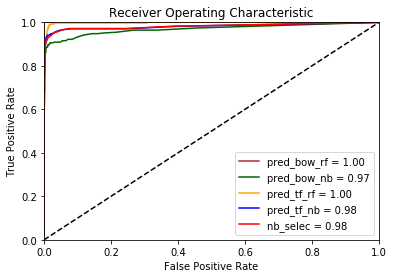

In [32]:
plt.title('Receiver Operating Characteristic')
modelos = ['pred_bow_rf', 'pred_bow_nb', 'pred_tf_rf', 'pred_tf_nb', 'nb_selec']
colors = ['brown', 'darkgreen', 'orange', 'blue', 'red']
for i in range(5):
    if i < 4:
        x = mod[5:]
    mod = modelos[i]
    probs = predicted_proba[x]
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test[mod], preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c = colors[i], label = mod + ' = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Vemos en general un gran desempeño de todos los métodos y que ambos métodos con Random Forest se pegan más al eje y pero en general todos los métodos lo hacen muy rápido.